In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn 

## Predicting Customer Churn
In this notebook, we'll take a look at a data set from a telecommunications company.  The goal is to develop both a predictive and descriptive model for customer churn.  Insights gained from a well-performing model can help the company understand factors associated with churn and identify which customers have a high probability of ending their service so that focused retention efforts can be deployed.

The data is from IBM Watson Analytics sample data sets which can be found at the following website:

Customer Support ---> Telco Customer Churn<br>
https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

In [2]:
# Import and inspect data
df = pd.read_csv('churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Inspect data for missing data and correct data types.  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
# Class counts
df.groupby('Churn').size()

Churn
No     5174
Yes    1869
dtype: int64

In [5]:
# Total charges is an object but should be numeric.  Strip whitespace first (get an error message when trying to 
# initially convert) and convert to numeric.
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [6]:
# Confirm change made
# Total charges successfully converted to numeric but now we see there are 11 missing values.
# Ignore missing values for now because we'll end up dropping total charges later on
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), ob

## Feature Engineering

In [7]:
# Get list of columns
column_names = df.columns.tolist()
column_names

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [8]:
# Pull out continuous columns
continuous_column_names = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create list of categorical columns by removing continous columns using .difference()
categorical_column_names = list(set(column_names).difference(continuous_column_names))

# Remove customer ID, churn from list since the former doesn't give us useful information and 
# the latter is our target variable
categorical_column_names.remove('customerID')
categorical_column_names.remove('Churn')

In [9]:
# Use feature lists to generate new df's
continuous_features = df.loc[:, continuous_column_names]
continuous_features.head()

categorical_features = df.loc[:, categorical_column_names]
categorical_features.head()

,PaymentMethod,OnlineBackup,TechSupport,DeviceProtection,MultipleLines,SeniorCitizen,PaperlessBilling,PhoneService,StreamingMovies,OnlineSecurity,gender,Partner,Contract,InternetService,Dependents,StreamingTV
0,Electronic check,Yes,No,No,No phone service,0,Yes,No,No,No,Female,Yes,Month-to-month,DSL,No,No
1,Mailed check,No,No,Yes,No,0,No,Yes,No,Yes,Male,No,One year,DSL,No,No
2,Mailed check,Yes,No,No,No,0,Yes,Yes,No,Yes,Male,No,Month-to-month,DSL,No,No
3,Bank transfer (automatic),No,Yes,Yes,No phone service,0,No,No,No,Yes,Male,No,One year,DSL,No,No
4,Electronic check,No,No,No,No,0,Yes,Yes,No,No,Female,No,Month-to-month,Fiber optic,No,No


In [10]:
# Create dummy variables (n-1) for categorical features
categorical_features = pd.get_dummies(categorical_features, drop_first=True)
print(categorical_features.shape)
categorical_features.head()

(7043, 27)


,SeniorCitizen,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No internet service,OnlineBackup_Yes,TechSupport_No internet service,TechSupport_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,...,OnlineSecurity_Yes,gender_Male,Partner_Yes,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,Dependents_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,1,...,1,1,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


                 tenure  MonthlyCharges  TotalCharges
tenure          1.00000        0.247900      0.825880
MonthlyCharges  0.24790        1.000000      0.651065
TotalCharges    0.82588        0.651065      1.000000


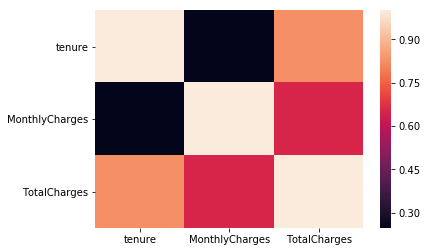

In [11]:
# Examine correlation between continous variables
# Tenure and total charges highly correlated.  Remove total charges from features
print(continuous_features.corr())
sns.heatmap(continuous_features.corr())
plt.show()

In [12]:
continuous_features = continuous_features.drop('TotalCharges', axis=1)
continuous_features.head()

,tenure,MonthlyCharges
0,1,29.85
1,34,56.95
2,2,53.85
3,45,42.30
4,2,70.70


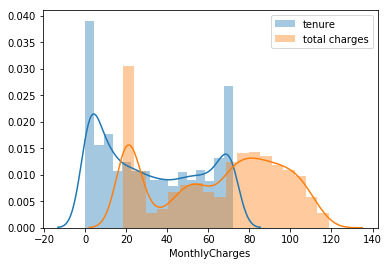

In [13]:
# Examine distribution of continous variables
sns.distplot(continuous_features.tenure, label='tenure')
sns.distplot(continuous_features.MonthlyCharges, label='total charges')
plt.legend()
plt.show()

In [14]:
from sklearn.preprocessing import normalize

# Normalize, put back into data frame so we can merge with categorical features
continuous_features_norm = pd.DataFrame(normalize(continuous_features))
continuous_features_norm = continuous_features_norm.rename({0: 'tenure_norm', 1: 'MonthlyCharges_norm'}, axis=1)
continuous_features_norm.head()

,tenure_norm,MonthlyCharges_norm
0,0.033482,0.999439
1,0.512610,0.858622
2,0.037115,0.999311
3,0.728628,0.684910
4,0.028277,0.999600


In [15]:
# Combine categorical and continuous into feature set
features = pd.concat([continuous_features_norm, categorical_features], axis=1)
print(features.shape)
features.head()

(7043, 29)


,tenure_norm,MonthlyCharges_norm,SeniorCitizen,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No internet service,OnlineBackup_Yes,TechSupport_No internet service,TechSupport_Yes,...,OnlineSecurity_Yes,gender_Male,Partner_Yes,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,Dependents_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,0.033482,0.999439,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.512610,0.858622,0,0,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
2,0.037115,0.999311,0,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0.728628,0.684910,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
4,0.028277,0.999600,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
# Create target variable, look at class balance again.
# Churn represents ~27% of the data set so we have a class imbalance
target = pd.get_dummies(df.loc[:, 'Churn'], drop_first=True)
print(target.mean())
target.head()

Yes    0.26537
dtype: float64


,Yes
0,0
1,0
2,1
3,0
4,1


In [17]:
# Split data into training/testing sets, use stratification to maintain class balance.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target)

## Models

In [18]:
# logistic regression, tree, random forest